In [1]:
import sys
sys.path.append('..')

from IPython.display import clear_output, display

from utils.config_reader import ConfigReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

def load_config(config_file):
    return ConfigReader(config_file).cfg

In [2]:
config_file = '../configs/cgem_evaluate_config.yaml'

config = load_config(config_file)

In [3]:
from utils.old_visualizer import Visualizer, draw_single
from utils.config_reader import ConfigReader
from utils.utils import get_events_df, parse_df, calc_purity_reduce_factor, apply_edge_restriction, apply_node_restriction
from utils.graph import to_nx_graph, to_line_graph, get_weight_stats, \
    get_linegraph_superedges_stat, to_pandas_graph_df, get_linegraph_stats_from_pandas, \
    get_reduced_df_graph, get_pd_line_graph, run_mbt_graph


In [4]:
df = parse_df(config['df'])

In [5]:
df.x.min(), df.x.max(), df.y.min(), df.y.max(), df.z.min(), df.z.max()
df

,event,x,y,z,station,track
0,0,80.14192,15.11591,191.199900,0,-1
1,0,-63.89627,50.68022,-227.884400,0,-1
2,0,-63.89627,50.68022,197.887000,0,-1
3,0,-66.23155,47.58781,-232.431900,0,-1
4,0,-66.23155,47.58781,-31.974340,0,-1
...,...,...,...,...,...,...
10241246,199999,113.19590,-55.46663,-9.057016,1,15
10241247,199999,148.49450,-75.43168,-11.174930,2,15
10241248,199999,-80.06099,15.53888,57.396880,0,17
10241249,199999,-124.25600,21.22056,90.268650,1,17


In [6]:
events = get_events_df(config['df']['take'], df, preserve_fakes=True)

In [7]:
events

,event,station,track,z,r,phi
0,0,0,-1,0.725738,0.489526,0.186424
1,0,0,-1,0.230951,0.489526,2.471034
2,0,0,-1,0.733633,0.489526,2.471034
3,0,0,-1,0.225582,0.489526,2.518554
4,0,0,-1,0.462250,0.489526,2.518554
...,...,...,...,...,...,...
10241246,199999,1,15,0.489307,0.756633,-0.455620
10241247,199999,2,15,0.486806,0.999730,-0.470008
10241248,199999,0,17,0.567765,0.489526,2.949888
10241249,199999,1,17,0.606575,0.756633,2.972444


In [8]:
events_to_analyze = events[events.event < 1000]
segments = pd.DataFrame()
for id, event in events_to_analyze.groupby('event'):
    clear_output(wait=True)
    display("Event #%09d" % id)
    G = to_pandas_graph_df(event, suffx=('_p', '_c'), compute_is_true_track=True)
    segments = segments.append(G)

'Event #000000999'

In [9]:
segments

,event,station_p,track_p,z_p,r_p,phi_p,index_old_p,station_c,track_c,z_c,r_c,phi_c,index_old_c,track
0,0,0,-1,0.725738,0.489526,0.186424,0,1,-1,0.788574,0.756633,0.171393,16,False
1,0,0,-1,0.725738,0.489526,0.186424,0,1,-1,0.180418,0.756633,2.477852,17,False
2,0,0,-1,0.725738,0.489526,0.186424,0,1,-1,0.522342,0.756633,2.477852,18,False
3,0,0,-1,0.725738,0.489526,0.186424,0,1,-1,0.623262,0.756633,2.477852,19,False
4,0,0,-1,0.725738,0.489526,0.186424,0,1,-1,0.797990,0.756633,2.477852,20,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,999,1,14,0.358580,0.756633,-0.294021,50995,2,-1,0.493208,0.999730,-0.799485,50986,False
188,999,1,14,0.358580,0.756633,-0.294021,50995,2,-1,0.318900,0.999730,-0.223371,50987,False
189,999,1,14,0.358580,0.756633,-0.294021,50995,2,9,0.757477,0.999730,0.037654,50990,False
190,999,1,14,0.358580,0.756633,-0.294021,50995,2,12,0.502497,0.999730,-0.799485,50993,False


In [10]:
def calc_dphi(phi1, phi2):
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

segments['dz'] = segments.z_c.values - segments.z_p.values
segments['dr'] = segments.r_c.values - segments.r_p.values
segments['dphi'] = calc_dphi(segments.phi_p.values, segments.phi_c.values)


true_segs = segments[segments.track]
fake_segs = segments[segments.track == False]

In [11]:
segments['dr'].describe()

count    1.193870e+06
mean     2.543025e-01
std      1.197815e-02
min      2.430966e-01
25%      2.430972e-01
50%      2.430976e-01
75%      2.671068e-01
max      2.671072e-01
Name: dr, dtype: float64

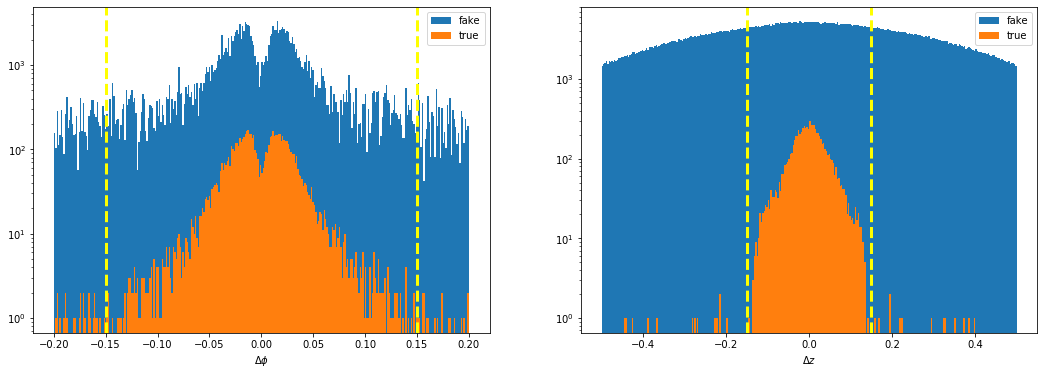

In [15]:
plt.figure(figsize=(18,6))

plt.subplot(121)
binning=dict(bins=300, range=(-0.2, 0.2))
plt.hist(fake_segs.dphi, label='fake', log=True, **binning)
plt.hist(true_segs.dphi, label='true', **binning)
plt.axvline(-0.15, color='yellow', linestyle='dashed', linewidth=3)
plt.axvline(0.15, color='yellow', linestyle='dashed', linewidth=3)

plt.xlabel('$\Delta\phi$')
plt.legend(loc=0)

plt.subplot(122)
binning=dict(bins=300, range=(-0.5, 0.5))
plt.hist(fake_segs.dz, label='fake', log=True, **binning)
plt.hist(true_segs.dz, label='true', **binning)
plt.axvline(-0.15, color='yellow', linestyle='dashed', linewidth=3)
plt.axvline(0.15, color='yellow', linestyle='dashed', linewidth=3)
plt.xlabel('$\Delta z$')
plt.legend(loc=0)


In [34]:
def filter_segments(df, dphi_min, dphi_max, dz_min, dz_max):
    return df[
        (df.dphi > dphi_min) & (df.dphi < dphi_max) &
        (df.dz > dz_min) & (df.dz < dz_max)
    ]


dphi_minmax = (-0.18, 0.18)
dz_minmax = (-0.15, 0.15)

filtered = filter_segments(segments, *dphi_minmax, *dz_minmax)

purity_, reduce_ = calc_purity_reduce_factor(segments, filtered, 'track', False)
print("Initial fake to real ratio is %.6f" % (len(segments) / len(segments[segments.track])))
print("Currently fake to real ratio is %.6f" % (len(filtered) / len(filtered[filtered.track])))
print("Result purity %.3f; segments filtering reduced ratio in %.3f times" % (purity_, reduce_))

Initial fake to real ratio is 154.246770
Currently fake to real ratio is 12.278873
Result purity 0.990; segments filtering reduced ratio in 12.688 times
